<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/CT_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Edited: Sama
# Spleen 3D segmentation with MONAI



## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib


from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

2023-12-11 14:39:23.488065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 14:39:23.488136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 14:39:23.488183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 14:39:28.737180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Task09_Spleen.tar: 1.50GB [01:49, 14.8MB/s]                            

2023-12-11 14:41:24,907 - INFO - Downloaded: /tmp/tmpof8d8v0p/Task09_Spleen.tar


2023-12-11 14:41:27,817 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-12-11 14:41:27,820 - INFO - Writing into directory: /tmp/tmpof8d8v0p.


## Setup imports

## Set MSD Spleen dataset path

In [ ]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = train_images
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]
set_determinism(seed=0)

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image", "label"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


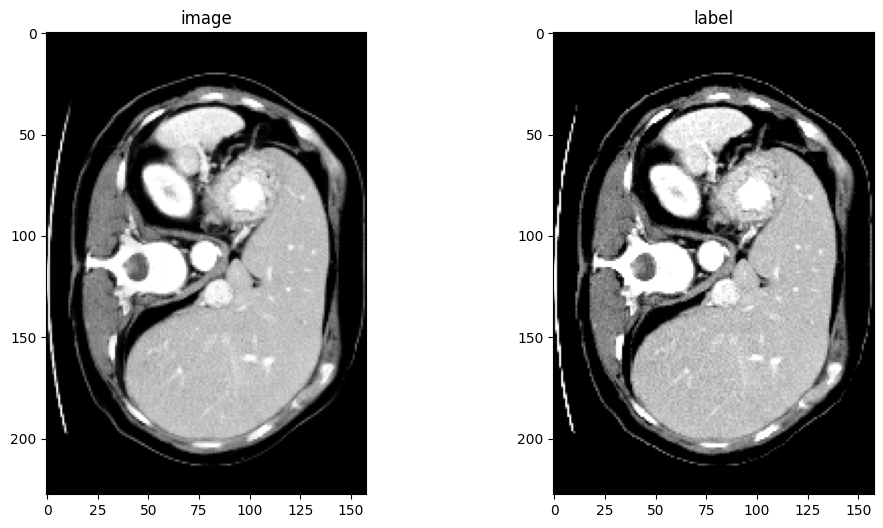

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80], cmap="gray")
plt.show()

## Define CacheDataset and DataLoader

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:28<00:00,  3.15s/it]


## Create Model, Loss, Optimizer

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,  # Single channel for regression output
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

In [ ]:
max_epochs = 5
val_interval = 2
best_metric = float('inf')  # Initialize with infinity, since lower MSE is better
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                # Compute MSE for current iteration
                val_loss += loss_function(val_outputs, val_labels).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_loss:.4f}"
                f"\nbest val loss: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/5
1/16, train_loss: 224881.6094
2/16, train_loss: 198503.7500
3/16, train_loss: 266867.9688
4/16, train_loss: 232932.4844
5/16, train_loss: 167399.1719
6/16, train_loss: 270783.4062
7/16, train_loss: 204805.5938
8/16, train_loss: 243048.9531
9/16, train_loss: 258836.8594
10/16, train_loss: 260032.3906
11/16, train_loss: 283586.0625
12/16, train_loss: 304573.4375
13/16, train_loss: 226304.5156
14/16, train_loss: 217028.7969
15/16, train_loss: 332982.1562
16/16, train_loss: 395574.6562
epoch 1 average loss: 255508.8633
----------
epoch 2/5
1/16, train_loss: 367294.8125
2/16, train_loss: 170741.9688
3/16, train_loss: 260840.0781
4/16, train_loss: 272792.1562
5/16, train_loss: 182649.0312
6/16, train_loss: 251610.6719
7/16, train_loss: 342774.6562
8/16, train_loss: 338972.6562
9/16, train_loss: 255870.8906
10/16, train_loss: 245371.6875
11/16, train_loss: 293675.5625
12/16, train_loss: 134520.8906
13/16, train_loss: 245917.1094
14/16, train_loss: 243821.1562
15/16, train

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1221 at epoch: 2


## Plot the loss and metric

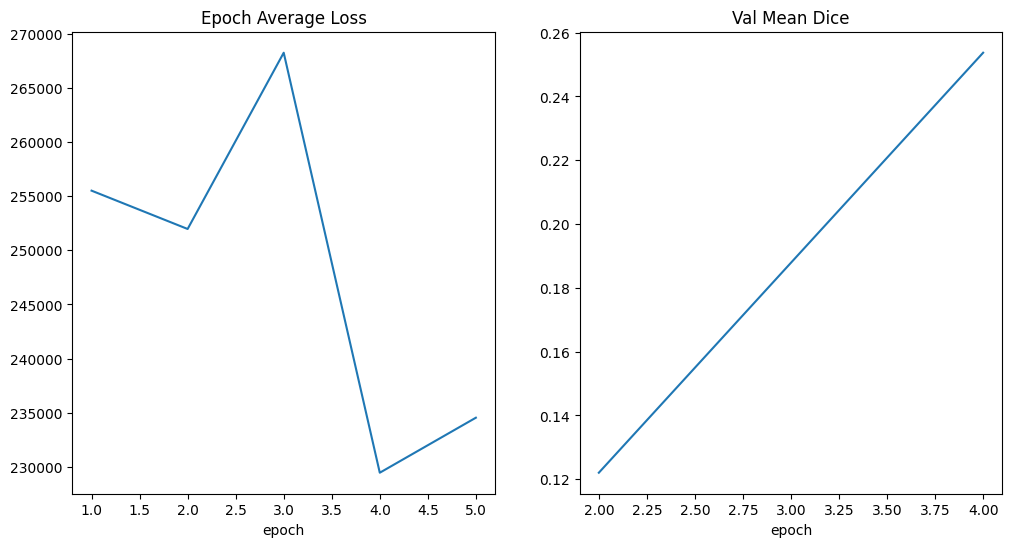

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

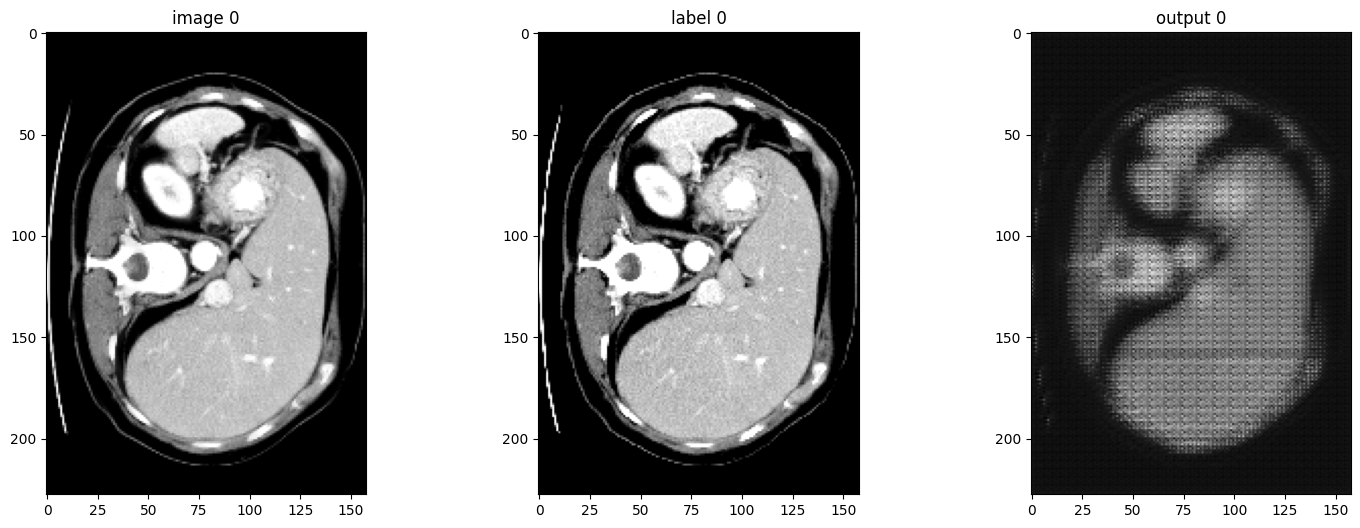

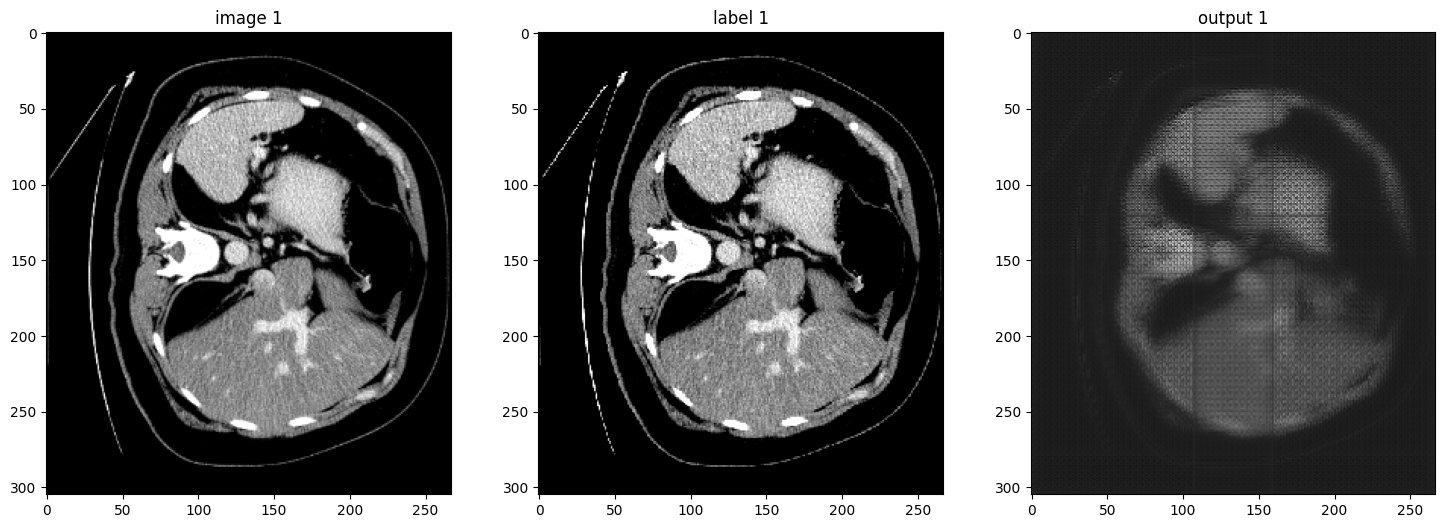

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()
# with torch.no_grad():
#     for i, val_data in enumerate(val_loader):
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

#         # plot the slice [:, :, 80]
#         plt.figure("check", (18, 6))
#         plt.subplot(1, 3, 1)
#         plt.title(f"image {i}")
#         plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")


#         plt.subplot(1, 3, 2)
#         plt.title(f"label {i}")
#         plt.imshow(val_data["label"][0, 0, :, :, 80])


#         plt.subplot(1, 3, 3)
#         plt.title(f"output {i}")
#         plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
#         plt.show()
#         if i == 1:
#             break

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        output_slice = val_outputs.detach().cpu()[0, 0, :, :, 80]
        # Assuming the output values are normalized, adjust if not
        plt.imshow(output_slice, cmap="gray")
        plt.show()
        if i == 1:
            break


## Evaluation on original image spacings

In [ ]:
# val_org_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#     ]
# )

# val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
# val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=val_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#             device="cpu",
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=2),
#         AsDiscreted(keys="label", to_onehot=2),
#     ]
# )

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()

# with torch.no_grad():
#     for val_data in val_org_loader:
#         val_inputs = val_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
#         val_data = [post_transforms(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
#         # compute metric for current iteration
#         dice_metric(y_pred=val_outputs, y=val_labels)

#     # aggregate the final mean dice result
#     metric_org = dice_metric.aggregate().item()
#     # reset the status for next validation round
#     dice_metric.reset()

# print("Metric on original image spacing: ", metric_org)

## Inference on Test Set

In [ ]:
# test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

# test_data = [{"image": image} for image in test_images]


# test_org_transforms = Compose(
#     [
#         LoadImaged(keys="image"),
#         EnsureChannelFirstd(keys="image"),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#     ]
# )

# test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

# test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=test_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=2),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
#     ]
# )

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Choose which image and which class channel to view
# image_index = 0  # Index of the image in the batch
# class_channel = 1  # Usually, 0 is the background, 1 is the class of interest

# # Assuming 'outputs' is your model output
# # Select the desired channel of the first image
# output_to_view = outputs[image_index, class_channel, :, :, 80]  # Choose a slice for 3D images

# # Convert to a NumPy array for visualization (if it's a tensor)
# if torch.is_tensor(output_to_view):
#     output_to_view = output_to_view.cpu().detach().numpy()

# # Plot the image
# plt.imshow(output_to_view, cmap='gray')
# plt.title('Model Output (Probability Map)')
# plt.show()


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)